## Установка зависимостей

In [1]:
!pip install -q open3d==0.19.0 torch torchvision torchaudio scikit-learn h5py tqdm seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 138.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.9 MB/s eta 0:00:00


## Загрузка и подготовка ModelNet40

In [4]:
import os

DATA_ROOT = "/content/data"
os.makedirs(DATA_ROOT, exist_ok=True)

%cd $DATA_ROOT

!wget http://modelnet.cs.princeton.edu/ModelNet40.zip -O ModelNet40.zip
!unzip -q ModelNet40.zip


/content/data
--2025-12-11 21:53:40--  http://modelnet.cs.princeton.edu/ModelNet40.zip
Resolving modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)... 128.112.136.67
Connecting to modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)|128.112.136.67|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://modelnet.cs.princeton.edu/ModelNet40.zip [following]
--2025-12-11 21:53:41--  https://modelnet.cs.princeton.edu/ModelNet40.zip
Connecting to modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)|128.112.136.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2039180837 (1.9G) [application/zip]
Saving to: ‘ModelNet40.zip’

ModelNet40.zip      100%[===================>]   1.90G  32.2MB/s    in 76s     

2025-12-11 21:54:57 (25.7 MB/s) - ‘ModelNet40.zip’ saved [2039180837/2039180837]



## Конвертация мешей в облака точек с Open3D

In [5]:
import numpy as np
import open3d as o3d

def load_off_mesh_fix(path: str) -> o3d.geometry.TriangleMesh:
    with open(path, "r") as f:
        header = f.readline().strip()

        # Случай 1: нормальный OFF
        if header == "OFF":
            n_verts, n_faces, _ = map(int, f.readline().split())
        # Случай 2: OFF1746 2676 0
        elif header.startswith("OFF"):
            rest = header[3:].strip()
            n_verts, n_faces, _ = map(int, rest.split())
        else:
            raise ValueError(f"Not an OFF file: {path}")

        # Вершины
        verts = []
        for _ in range(n_verts):
            verts.append(list(map(float, f.readline().split())))
        verts = np.array(verts, dtype=np.float32)

        # Грани
        faces = []
        for _ in range(n_faces):
            parts = f.readline().split()
            k = int(parts[0])
            assert k == 3  # OFF в ModelNet40 — треугольники
            faces.append(list(map(int, parts[1:4])))
        faces = np.array(faces, dtype=np.int32)

    mesh = o3d.geometry.TriangleMesh(
        vertices=o3d.utility.Vector3dVector(verts),
        triangles=o3d.utility.Vector3iVector(faces),
    )
    mesh.compute_vertex_normals()
    return mesh

def sample_point_cloud_from_mesh(path, n_points=1024):
    try:
        mesh = load_off_mesh_fix(path)
    except Exception as e:
        print(f"[WARN] Failed to parse {path}: {e}")
        return None

    if mesh.is_empty() or len(mesh.triangles) == 0:
        print(f"[WARN] Skipping {path}: empty mesh or no triangles")
        return None

    pcd = mesh.sample_points_uniformly(number_of_points=n_points)
    points = np.asarray(pcd.points, dtype=np.float32)

    # Нормализация в [-1, 1]
    centroid = points.mean(axis=0)
    points = points - centroid
    scale = np.max(np.linalg.norm(points, axis=1))
    if scale > 0:
        points = points / scale

    return points

In [6]:
import os
from glob import glob
import numpy as np

MAX_CLASSES = 10           # Объёмы обучающей выборки пришлось урезать, чтобы
MAX_TRAIN_PER_CLASS = 30   # влезть в ограничения Colab
MAX_TEST_PER_CLASS = 10    #
N_POINTS = 1024            #

MODELNET_DIR = "/content/data/ModelNet40"


classes = sorted([d for d in os.listdir(MODELNET_DIR)
                  if os.path.isdir(os.path.join(MODELNET_DIR, d))])[:MAX_CLASSES]
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

print("Используем классы:", classes)
print("Их количество:", len(classes))

Используем классы: ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone']
Их количество: 10


Тестовый tqdm для проверки корректности работы в colab

In [7]:
from tqdm import tqdm
import time

for i in tqdm(range(200), desc="Slow test", ascii=True):
    time.sleep(0.01)


Slow test: 100%|##########| 200/200 [00:02<00:00, 98.26it/s]


In [ ]:
train_points = []
train_labels = []
test_points = []
test_labels = []

for cls_name in tqdm(classes, desc="Classes", ascii=True):
    cls_dir = os.path.join(MODELNET_DIR, cls_name)
    if not os.path.isdir(cls_dir):
        continue

    label = class_to_idx[cls_name]

    # train
    train_files = glob(os.path.join(cls_dir, "train", "*.off"))
    for f in train_files:
        pts = sample_point_cloud_from_mesh(f, N_POINTS)
        if pts is None:
            continue
        train_points.append(pts)
        train_labels.append(label)

    # test
    test_files = glob(os.path.join(cls_dir, "test", "*.off"))
    for f in test_files:
        pts = sample_point_cloud_from_mesh(f, N_POINTS)
        if pts is None:
            continue
        test_points.append(pts)
        test_labels.append(label)

X_train = np.stack(train_points, axis=0)
y_train = np.array(train_labels, dtype=np.int64)
X_test = np.stack(test_points, axis=0)
y_test = np.array(test_labels, dtype=np.int64)

print("X_train:", X_train.shape, "X_test:", X_test.shape)


Classes: 100%|##########| 10/10 [14:22<00:00, 86.29s/it]

X_train: (3644, 1024, 3) X_test: (710, 1024, 3)


In [ ]:
np.save(os.path.join(DATA_ROOT, "modelnet40_X_train.npy"), X_train)
np.save(os.path.join(DATA_ROOT, "modelnet40_y_train.npy"), y_train)
np.save(os.path.join(DATA_ROOT, "modelnet40_X_test.npy"), X_test)
np.save(os.path.join(DATA_ROOT, "modelnet40_y_test.npy"), y_test)


In [8]:
X_train = np.load("/content/modelnet40_X_train.npy")
y_train = np.load("/content/modelnet40_y_train.npy")
X_test = np.load("/content/modelnet40_X_test.npy")
y_test = np.load("/content/modelnet40_y_test.npy")

In [9]:
import h5py

with h5py.File(os.path.join(DATA_ROOT, "modelnet40_points.h5"), "w") as f:
    f.create_dataset("X_train", data=X_train)
    f.create_dataset("y_train", data=y_train)
    f.create_dataset("X_test", data=X_test)
    f.create_dataset("y_test", data=y_test)


## Класс модели

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TNet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k = k
        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k * k)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
        # x: (B, k, N)
        B = x.size(0)

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2)[0]  # (B, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)  # (B, k*k)

        ident = torch.eye(self.k, device=x.device).view(1, self.k * self.k).repeat(B, 1)
        x = x + ident
        x = x.view(-1, self.k, self.k)
        return x

class PointNetCls(nn.Module):
    def __init__(self, num_classes=40, feature_transform=True):
        super().__init__()
        self.feature_transform = feature_transform

        self.input_tnet = TNet(k=3)
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.bn1 = nn.BatchNorm1d(64)

        self.feature_tnet = TNet(k=64)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # x: (B, N, 3) -> (B, 3, N)
        x = x.transpose(2, 1)

        # Input Transform
        trans = self.input_tnet(x)       # (B, 3, 3)
        x = torch.bmm(trans, x)          # (B, 3, N)

        x = F.relu(self.bn1(self.conv1(x)))  # (B, 64, N)

        # Feature Transform (опционально)
        if self.feature_transform:
            trans_feat = self.feature_tnet(x)  # (B, 64, 64)
            x = torch.bmm(trans_feat, x)
        else:
            trans_feat = None

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))      # (B, 1024, N)
        x = torch.max(x, 2)[0]           # глобальный max pooling -> (B, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)                  # (B, num_classes)

        return x, trans_feat


## Подготовка DataLoader'ов

In [11]:
from torch.utils.data import Dataset, DataLoader

class ModelNet40Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()  # (N, 1024, 3)
        self.y = torch.from_numpy(y).long()   # (N,)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ModelNet40Dataset(X_train, y_train)
test_dataset = ModelNet40Dataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


## Оптимизатор, критерии и девайсы

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(classes)

model = PointNetCls(num_classes=num_classes, feature_transform=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50

train_losses = []
test_losses = []
train_accs = []
test_accs = []


## Процесс обучения

In [13]:
def eval_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    loss_sum = 0.0

    with torch.no_grad():
        for pts, labels in loader:
            pts = pts.to(device)
            labels = labels.to(device)

            outputs, _ = model(pts)
            loss = criterion(outputs, labels)
            loss_sum += loss.item() * pts.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return loss_sum / total, correct / total

for epoch in tqdm(range(1, num_epochs + 1), ascii=True):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for pts, labels in train_loader:
        pts = pts.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs, _ = model(pts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * pts.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = running_correct / total

    test_loss, test_acc = eval_model(model, test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch {epoch:03d}: "
          f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
          f"Test Loss={test_loss:.4f}, Acc={test_acc:.4f}")


  2%|2         | 1/50 [00:10<08:12, 10.06s/it]

Epoch 001: Train Loss=0.6230, Acc=0.8106 | Test Loss=0.6633, Acc=0.7592


  4%|4         | 2/50 [00:16<06:33,  8.19s/it]

Epoch 002: Train Loss=0.3039, Acc=0.9053 | Test Loss=0.2931, Acc=0.8958


  6%|6         | 3/50 [00:24<06:01,  7.70s/it]

Epoch 003: Train Loss=0.2015, Acc=0.9418 | Test Loss=0.2336, Acc=0.9113


  8%|8         | 4/50 [00:31<05:41,  7.42s/it]

Epoch 004: Train Loss=0.1616, Acc=0.9539 | Test Loss=0.2139, Acc=0.9380


 10%|#         | 5/50 [00:37<05:25,  7.24s/it]

Epoch 005: Train Loss=0.1308, Acc=0.9660 | Test Loss=0.0765, Acc=0.9746


 12%|#2        | 6/50 [00:44<05:15,  7.16s/it]

Epoch 006: Train Loss=0.1144, Acc=0.9684 | Test Loss=0.2565, Acc=0.9169


 14%|#4        | 7/50 [00:52<05:06,  7.13s/it]

Epoch 007: Train Loss=0.0972, Acc=0.9726 | Test Loss=0.0828, Acc=0.9761


 16%|#6        | 8/50 [00:59<04:58,  7.11s/it]

Epoch 008: Train Loss=0.1346, Acc=0.9654 | Test Loss=0.0841, Acc=0.9718


 18%|#8        | 9/50 [01:06<04:51,  7.10s/it]

Epoch 009: Train Loss=0.1054, Acc=0.9715 | Test Loss=0.0983, Acc=0.9732


 20%|##        | 10/50 [01:13<04:43,  7.09s/it]

Epoch 010: Train Loss=0.0810, Acc=0.9769 | Test Loss=0.0820, Acc=0.9732


 22%|##2       | 11/50 [01:20<04:37,  7.10s/it]

Epoch 011: Train Loss=0.0708, Acc=0.9802 | Test Loss=0.1407, Acc=0.9634


 24%|##4       | 12/50 [01:27<04:30,  7.12s/it]

Epoch 012: Train Loss=0.0848, Acc=0.9764 | Test Loss=0.1017, Acc=0.9732


 26%|##6       | 13/50 [01:34<04:24,  7.15s/it]

Epoch 013: Train Loss=0.0438, Acc=0.9877 | Test Loss=0.0612, Acc=0.9831


 28%|##8       | 14/50 [01:42<04:18,  7.17s/it]

Epoch 014: Train Loss=0.0640, Acc=0.9805 | Test Loss=0.0760, Acc=0.9789


 30%|###       | 15/50 [01:49<04:11,  7.19s/it]

Epoch 015: Train Loss=0.0653, Acc=0.9808 | Test Loss=0.1120, Acc=0.9634


 32%|###2      | 16/50 [01:56<04:05,  7.22s/it]

Epoch 016: Train Loss=0.0735, Acc=0.9802 | Test Loss=0.1204, Acc=0.9676


 34%|###4      | 17/50 [02:03<03:59,  7.27s/it]

Epoch 017: Train Loss=0.0956, Acc=0.9778 | Test Loss=0.0935, Acc=0.9690


 36%|###6      | 18/50 [02:11<03:53,  7.29s/it]

Epoch 018: Train Loss=0.0667, Acc=0.9794 | Test Loss=0.1280, Acc=0.9592


 38%|###8      | 19/50 [02:18<03:45,  7.29s/it]

Epoch 019: Train Loss=0.0559, Acc=0.9822 | Test Loss=0.2123, Acc=0.9549


 40%|####      | 20/50 [02:25<03:38,  7.27s/it]

Epoch 020: Train Loss=0.0642, Acc=0.9816 | Test Loss=0.1513, Acc=0.9592


 42%|####2     | 21/50 [02:33<03:30,  7.27s/it]

Epoch 021: Train Loss=0.0431, Acc=0.9871 | Test Loss=0.0982, Acc=0.9704


 44%|####4     | 22/50 [02:40<03:24,  7.29s/it]

Epoch 022: Train Loss=0.0675, Acc=0.9827 | Test Loss=0.1142, Acc=0.9662


 46%|####6     | 23/50 [02:47<03:16,  7.28s/it]

Epoch 023: Train Loss=0.0362, Acc=0.9896 | Test Loss=0.0892, Acc=0.9732


 48%|####8     | 24/50 [02:54<03:08,  7.27s/it]

Epoch 024: Train Loss=0.0465, Acc=0.9863 | Test Loss=0.2128, Acc=0.9535


 50%|#####     | 25/50 [03:02<03:01,  7.25s/it]

Epoch 025: Train Loss=0.0610, Acc=0.9857 | Test Loss=0.0951, Acc=0.9732


 52%|#####2    | 26/50 [03:09<02:54,  7.26s/it]

Epoch 026: Train Loss=0.0409, Acc=0.9871 | Test Loss=0.0814, Acc=0.9803


 54%|#####4    | 27/50 [03:16<02:47,  7.27s/it]

Epoch 027: Train Loss=0.0395, Acc=0.9890 | Test Loss=0.3096, Acc=0.9141


 56%|#####6    | 28/50 [03:23<02:39,  7.26s/it]

Epoch 028: Train Loss=0.0567, Acc=0.9833 | Test Loss=0.1477, Acc=0.9634


 58%|#####8    | 29/50 [03:31<02:32,  7.27s/it]

Epoch 029: Train Loss=0.0553, Acc=0.9841 | Test Loss=0.0776, Acc=0.9746


 60%|######    | 30/50 [03:38<02:25,  7.26s/it]

Epoch 030: Train Loss=0.0820, Acc=0.9764 | Test Loss=0.0711, Acc=0.9803


 62%|######2   | 31/50 [03:45<02:17,  7.26s/it]

Epoch 031: Train Loss=0.0656, Acc=0.9772 | Test Loss=0.0902, Acc=0.9718


 64%|######4   | 32/50 [03:52<02:10,  7.25s/it]

Epoch 032: Train Loss=0.0518, Acc=0.9830 | Test Loss=0.0952, Acc=0.9732


 66%|######6   | 33/50 [04:00<02:03,  7.25s/it]

Epoch 033: Train Loss=0.0364, Acc=0.9890 | Test Loss=0.3765, Acc=0.9113


 68%|######8   | 34/50 [04:07<01:55,  7.25s/it]

Epoch 034: Train Loss=0.0317, Acc=0.9907 | Test Loss=0.0623, Acc=0.9789


 70%|#######   | 35/50 [04:14<01:48,  7.25s/it]

Epoch 035: Train Loss=0.0566, Acc=0.9830 | Test Loss=0.1694, Acc=0.9507


 72%|#######2  | 36/50 [04:21<01:41,  7.26s/it]

Epoch 036: Train Loss=0.0553, Acc=0.9857 | Test Loss=0.0827, Acc=0.9732


 74%|#######4  | 37/50 [04:29<01:34,  7.25s/it]

Epoch 037: Train Loss=0.0306, Acc=0.9912 | Test Loss=0.0663, Acc=0.9803


 76%|#######6  | 38/50 [04:36<01:26,  7.24s/it]

Epoch 038: Train Loss=0.0335, Acc=0.9904 | Test Loss=0.1020, Acc=0.9761


 78%|#######8  | 39/50 [04:43<01:19,  7.25s/it]

Epoch 039: Train Loss=0.0250, Acc=0.9920 | Test Loss=0.0827, Acc=0.9746


 80%|########  | 40/50 [04:50<01:12,  7.27s/it]

Epoch 040: Train Loss=0.0248, Acc=0.9923 | Test Loss=0.0933, Acc=0.9718


 82%|########2 | 41/50 [04:58<01:05,  7.27s/it]

Epoch 041: Train Loss=0.0260, Acc=0.9915 | Test Loss=0.0760, Acc=0.9746


 84%|########4 | 42/50 [05:05<00:58,  7.26s/it]

Epoch 042: Train Loss=0.0219, Acc=0.9937 | Test Loss=0.0938, Acc=0.9775


 86%|########6 | 43/50 [05:12<00:50,  7.26s/it]

Epoch 043: Train Loss=0.0282, Acc=0.9920 | Test Loss=0.0763, Acc=0.9803


 88%|########8 | 44/50 [05:19<00:43,  7.26s/it]

Epoch 044: Train Loss=0.0511, Acc=0.9879 | Test Loss=0.1007, Acc=0.9704


 90%|######### | 45/50 [05:27<00:36,  7.28s/it]

Epoch 045: Train Loss=0.0363, Acc=0.9890 | Test Loss=0.0535, Acc=0.9817


 92%|#########2| 46/50 [05:34<00:29,  7.27s/it]

Epoch 046: Train Loss=0.0262, Acc=0.9934 | Test Loss=0.0546, Acc=0.9845


 94%|#########3| 47/50 [05:41<00:21,  7.27s/it]

Epoch 047: Train Loss=0.0248, Acc=0.9920 | Test Loss=0.0633, Acc=0.9775


 96%|#########6| 48/50 [05:49<00:14,  7.26s/it]

Epoch 048: Train Loss=0.0295, Acc=0.9901 | Test Loss=0.1247, Acc=0.9662


 98%|#########8| 49/50 [05:56<00:07,  7.26s/it]

Epoch 049: Train Loss=0.0441, Acc=0.9874 | Test Loss=0.0630, Acc=0.9817


100%|##########| 50/50 [06:03<00:00,  7.27s/it]

Epoch 050: Train Loss=0.0162, Acc=0.9959 | Test Loss=0.1160, Acc=0.9775


In [17]:
import torch
torch.save(model.state_dict(), "/content/weights.pt")

## Графики потерь и точности

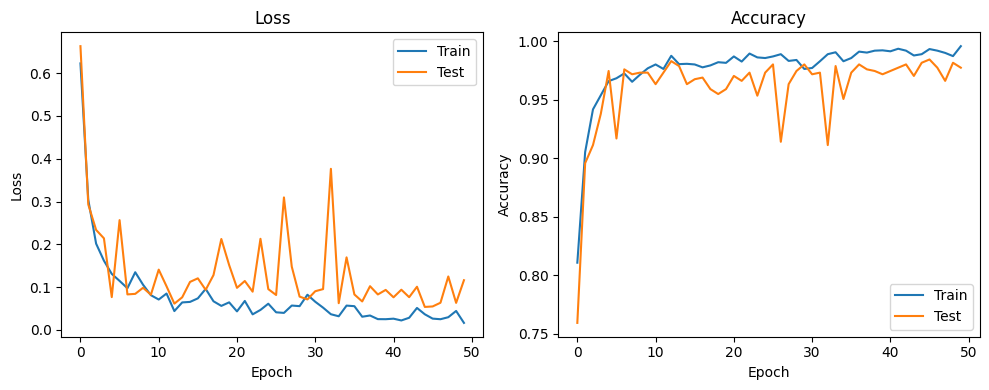

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train")
plt.plot(test_accs, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.tight_layout()
plt.show()


## Confusion matrix

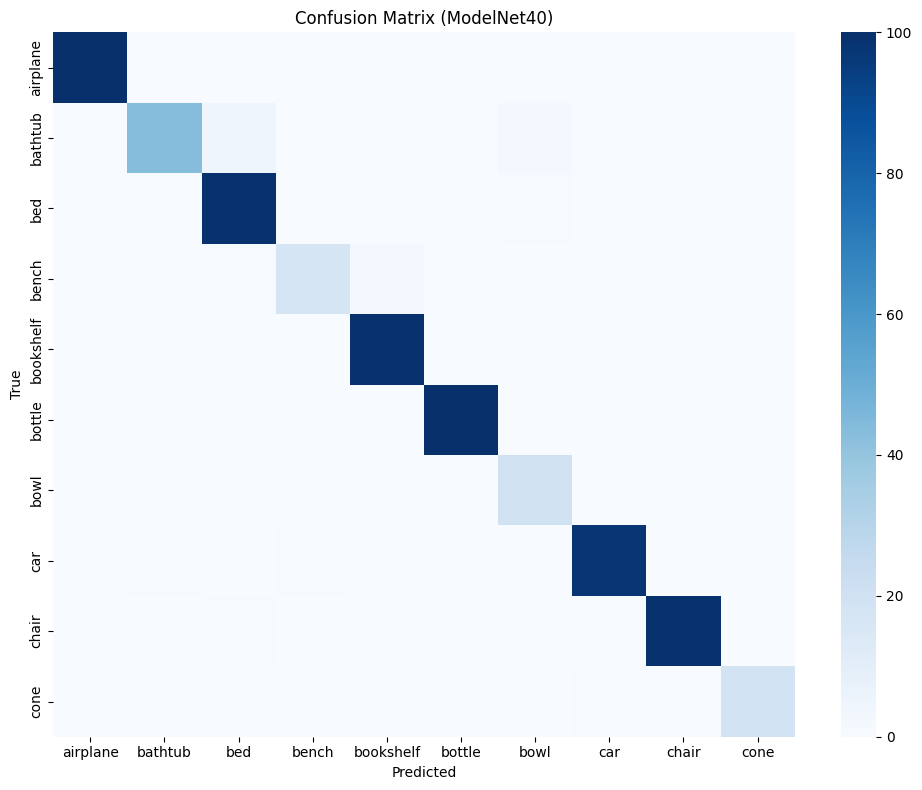

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Собираем все предсказания на тесте
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for pts, labels in test_loader:
        pts = pts.to(device)
        labels = labels.to(device)

        outputs, _ = model(pts)
        _, preds = torch.max(outputs, 1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (ModelNet40)")
plt.tight_layout()
plt.show()


## Примеры предсказаний из теста

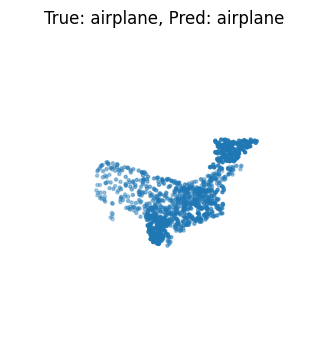

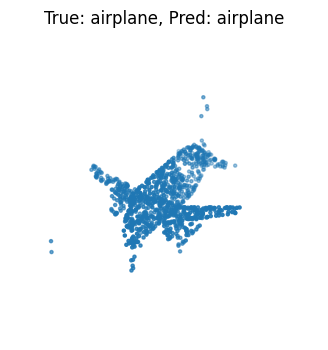

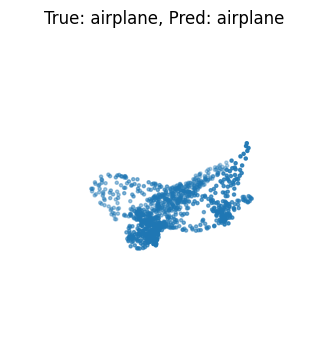

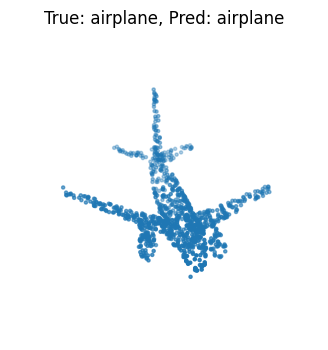

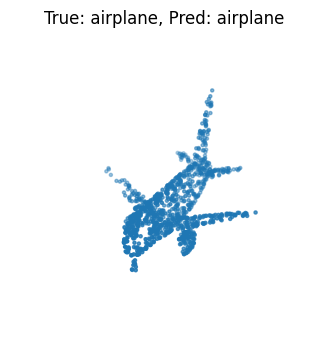

In [16]:
from mpl_toolkits.mplot3d import Axes3D  # noqa

def show_point_cloud(points, title=""):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:,0], points[:,1], points[:,2], s=5)
    ax.set_title(title)
    ax.set_axis_off()
    plt.show()

# Несколько примеров из теста
model.eval()
for i in range(5):
    pts = X_test[i]           # (1024, 3)
    label = y_test[i]
    inp = torch.from_numpy(pts).unsqueeze(0).to(device)  # (1, 1024, 3)
    with torch.no_grad():
        out, _ = model(inp)
        pred = out.argmax(dim=1).item()

    true_name = classes[label]
    pred_name = classes[pred]
    title = f"True: {true_name}, Pred: {pred_name}"
    show_point_cloud(pts, title=title)
